In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import ranksums

import os
import glob
import sys
from datetime import date
import json

# from scipy.signal import medfilt
# from scipy.signal import find_peaks

from samb_work import dimtools as dimt

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.family':'Arial'})

today = date.today()
today = today.strftime("%Y_%m_%d")

if sys.platform == 'darwin':
    basedir = 'Volumes'
else:
    basedir = 'media'
    
pth = f'/{basedir}/HlabShare/appps1_cortical_communication_samb/figure_3/'

from matplotlib.colors import LinearSegmentedColormap
clist = [(0.1, 0.6, 1.0), (0.05, 0.05, 0.05), (0.8, 0.5, 0.1)]
blue_orange_divergent = LinearSegmentedColormap.from_list("custom_blue_orange", clist)

In [2]:
#                        Colors

with open(f'/{basedir}/HlabShare/appps1_cortical_communication_samb/geno_colors.json') as json_file:
    geno_clrs = json.load(json_file)

dump = 1

In [7]:
def z_score(binned, baseline_length = 20):
    binbl = np.hstack([binned[:,:baseline_length],binned[:,-baseline_length:]])
    binmean = np.nanmean(binbl,axis=1)
    binstd = np.nanstd(binbl,axis=1)
    binnum = binned - np.reshape(binmean,[np.shape(binmean)[0],1])
    bin_z = binnum/np.reshape(binstd,[np.shape(binstd)[0],1])
    return(bin_z)

def bonfcorr(pvals):
    
    from statsmodels.stats.multitest import multipletests as bonferonni

    #bonferroni correction for multiple comparisons
    pvals_bonf = bonferonni(pvals)[1]
    
    return pvals_bonf

def get_signif(pvals):
    pval_labs = np.zeros(len(pvals),dtype='object')

    pval_labs[pvals > 0.05] = ''
    pval_labs[pvals < 0.05] = '*'
    pval_labs[pvals < 0.005] = '**'
    pval_labs[pvals < 0.0001] = '***'

    pval_labs = pval_labs.tolist()
    
    return pval_labs

In [5]:
binsize = 0.001
shiftmax = 80
# epochlen_thresh = 120
# epochlen_thresh = 5*60
epochlen_thresh = 60

wtlist = ['CAF69', 'CAF77', 'CAF81', 'CAF82']
applist = ['CAF71', 'CAF73', 'CAF74', 'CAF75']

allenroidic = {'RSP - VISp': 'rsc_v1', 'RSP - ACAd': 'rsc_acc'}
statenames = {'active': 'wake', 'nrem': 'nrem'}

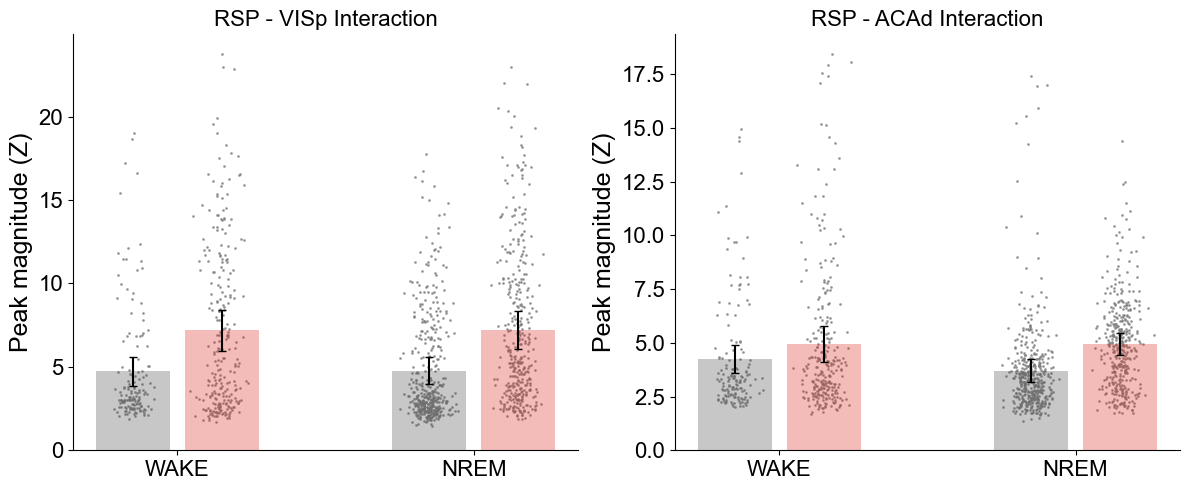

In [8]:
columnnames = ['genotype','peak_mag','state','inter']
magdf = pd.DataFrame(columns=columnnames)

for r, inter_rois in enumerate(['RSP - VISp','RSP - ACAd']):

    pwcdata_files = glob.glob(f'/{basedir}/HlabShare/SamB/APPplots/pwc/{allenroidic[inter_rois]}/*mean*.npy')

    sleepstates = ['active','nrem']

    for s, state_of_interest in enumerate(sleepstates):
        
        pwcdat_wt = np.zeros([1,161])
        pwcdat_app = np.zeros([1,161])

        pwcdata_files_state = [fil for fil in pwcdata_files if (fil.find(state_of_interest) > 0)]

        for fil in pwcdata_files_state:
            animal = fil.split('PWCmean_')[-1].split('_')[0]
            pwcdat_block = np.load(fil)
            fildir = fil.split('PWC')[0]
            filcsv = fil.split('/')[-1].replace('.npy','.csv').replace('mean','epochs')
            stats = pd.read_csv(fildir+filcsv)

            ##do some filtering of epochs
            rowstokeep = np.unique(stats[stats.epoch_len>epochlen_thresh].pwc_row)
            pwcdat_block_filtered = pwcdat_block[rowstokeep,:]

            if animal in wtlist: 
                pwcdat_wt = np.vstack([pwcdat_wt,pwcdat_block_filtered])
            elif animal in applist:
                pwcdat_app = np.vstack([pwcdat_app,pwcdat_block_filtered])

        #last step to remove first array
        pwcdat_wt = pwcdat_wt[1:,]
        pwcdat_app = pwcdat_app[1:,]
        
        #limit to -40,40 with z scoring in that range
        window = 40
        windind = np.arange(shiftmax -window, ((2*shiftmax) + 1) - (shiftmax-window))
        pwcdat_wt = pwcdat_wt[:,windind]
        pwcdat_app = pwcdat_app[:,windind]
        
        pwcdat_wt_z = z_score(pwcdat_wt)
        pwcdat_app_z = z_score(pwcdat_app)
        
        #remove data with large central peaks
        thresh = 20 #35
        pwcdat_wt_z = pwcdat_wt_z[pwcdat_wt_z[:,40] < thresh,:]
        pwcdat_app_z = pwcdat_app_z[pwcdat_app_z[:,40] < thresh,:]
        
        app_mean = np.nanmean(pwcdat_app_z,axis=0)
        wt_mean = np.nanmean(pwcdat_wt_z,axis=0)
        app_sem = np.nanstd(pwcdat_app_z,axis=0) / len(applist)
        wt_sem = np.nanstd(pwcdat_wt_z,axis=0) / len(wtlist)
        
        wt_mean_smooth = dimt.smooth_spikes(np.reshape(wt_mean,[1,(window*2)+1]),0.001,0.002).ravel()
        app_mean_smooth = dimt.smooth_spikes(np.reshape(app_mean,[1,((window*2)+1)]),0.001,0.002).ravel()
        

        uniqcond = np.array(['WT','APP'])
        for cond in uniqcond:
            if cond == 'WT':
                z_dat = pwcdat_wt_z.copy()
            elif cond == 'APP':
                z_dat = pwcdat_app_z.copy()
                
            peaks = np.max(z_dat,axis=1).astype('float')
            
            newdat = np.vstack([np.tile(cond.upper(),len(peaks)),peaks,
                                np.tile(state_of_interest,len(peaks)),
                                np.tile(allenroidic[inter_rois],len(peaks))]).T
            newdf = pd.DataFrame(newdat,columns=columnnames)
            magdf = magdf.append(newdf,ignore_index=True)
            magdf = magdf.explode('peak_mag')
            magdf['peak_mag'] = magdf['peak_mag'].astype('float')
            
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

for r, inter_rois in enumerate(['RSP - VISp','RSP - ACAd']):

    magdf_roi = magdf[magdf.inter==allenroidic[inter_rois]]

    peak_mean = np.zeros(len(sleepstates)*2)
    peak_sem = np.zeros(len(sleepstates)*2)
    count = 0
    # uniqcond = np.unique(magdf_roi.genotype)
    uniqcond = np.array(['WT','APP'])

    #for every condition and comparison, i.e. bar in the barplot
    for sleepstate in sleepstates:
        for cond in uniqcond:
            bar_cond = cond
            n_animals = 4
            bar_peaks = magdf_roi[(magdf_roi.genotype==bar_cond)&(magdf_roi.state==sleepstate)].peak_mag.values
            bar_sem = np.nanstd(bar_peaks) / n_animals
            peak_mean[count] = np.nanmean(bar_peaks)
            peak_sem[count] = bar_sem
            count += 1

    ###PLOT

    xpos = 0

    for i,comp in enumerate(sleepstates):
        for j,cond in enumerate(uniqcond):
            if j == 0:
                xfudge = 0.2
            elif j == 1:
                xfudge = -0.2

            ax[r].bar(xpos + xfudge,peak_mean[xpos],yerr = peak_sem[xpos],capsize=3,
                        color = geno_clrs[cond.upper()],alpha=0.3, align='center', width=0.5)

            plt_pts = magdf_roi[(magdf_roi.genotype==cond)&(magdf_roi.state==comp)].peak_mag.values
            plt_pts = plt_pts[~np.isnan(plt_pts)]

            jitter = np.random.randn(len(plt_pts)) / 15
            ax[r].scatter(np.tile(xpos + xfudge,len(plt_pts))+jitter,
                        plt_pts,s=1,c='grey',alpha=0.7,label='_nolegend_')

            xpos += 1

    ax[r].set_title(f'{inter_rois} Interaction', fontsize=16)
    ax[r].tick_params(axis='y', labelsize=16)
#     ax[r].set_ylim(0,3)

    xtickpos = np.arange(0,len(sleepstates)*2,2)
    ax[r].set_ylabel('Peak magnitude (Z)',fontsize = 18)
    ax[r].set_xlabel('')
    # plt.legend(uniqcond,fontsize=12,loc='upper right')
    ax[r].get_xaxis().set_ticks(xtickpos+0.5)
    ax[r].get_xaxis().set_ticklabels(['WAKE','NREM'],fontsize=16)

    ax[r].spines['right'].set_visible(False)
    ax[r].spines['top'].set_visible(False)

plt.tight_layout()

if dump:
    filename = f'lagged_corr_peakmag.pdf'
    plt.savefig(pth+today+filename,dpi=300,bbox_inches='tight')
else:
    pass

plt.show()

In [9]:
pvals = []
conds = []
teststat = []

sleepstates = np.unique(magdf.state)
for circuit in np.unique(magdf.inter):
    for sleepstate in sleepstates:
        dat = magdf[(magdf.inter==circuit)&(magdf.state==sleepstate)]
        wtdat = dat[dat.genotype=='WT']['peak_mag'].values
        appdat = dat[dat.genotype=='APP']['peak_mag'].values
        
        #remove nans from x and y before ranksums
        x = wtdat
        x2 = x[~np.isnan(x)]
        y = appdat
        y2 = y[~np.isnan(y)]
        
        #ranksums
        t_rs, p_rs = ranksums(x2,y2)
        cond = circuit + ' - ' + sleepstate
        pvals.append(p_rs)
        conds.append(cond)
        teststat.append(t_rs)
pvals_bonf = bonfcorr(pvals)
pval_labs = get_signif(pvals_bonf)

for i,j,k in zip(conds,pval_labs,teststat):
    print(i,j,np.round(k,3))

rsc_acc - active * -2.368
rsc_acc - nrem *** -10.795
rsc_v1 - active *** -4.811
rsc_v1 - nrem *** -9.288


In [10]:
conds

['rsc_acc - active', 'rsc_acc - nrem', 'rsc_v1 - active', 'rsc_v1 - nrem']

In [11]:
pvals_bonf

array([1.78949906e-02, 0.00000000e+00, 3.00325657e-06, 0.00000000e+00])